<a href="https://colab.research.google.com/github/gabetrix/public-datasets/blob/main/EAD_IA_Regressao_por_vetores_de_suporte_exercicio_boston_house_pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Caro aluno, como estamos utilizando várias técnicas de regressão precisamos de um critério de comparação entre os resultados do modelo. Algumas métricas que podem nos ajudar bastante comuns são: MAE (do inglês MEAN ABSOLUTE ERRROR) e o RMSE (do inglês ROOT MEAN SQUARE ERROR) que vamos usar nesse exercício.

Vamos predizer o preço de casas usando técnicas de regressão, para isso vamos utilizar a base de dados do preço de casas de Boston. Vamos nessa?

In [1]:
#Começamos importando as bibliotecas necessárias para visualização dos dados
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew

In [45]:
#Leitura dos dados já separados em bases de treinamento e teste
train = pd.read_csv('https://raw.githubusercontent.com/gabetrix/public-datasets/main/train.csv', sep=',')
test = pd.read_csv('https://raw.githubusercontent.com/gabetrix/public-datasets/main/test.csv', sep=',')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<ipython-input-10-f7b1626900d9>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['SalePrice'] , fit=norm);



 mu = 180921.20 and sigma = 79415.29



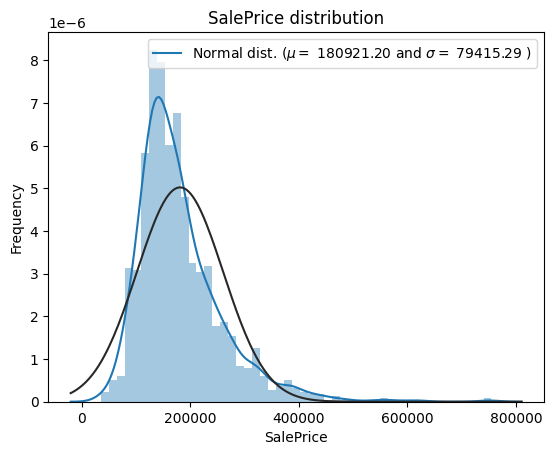

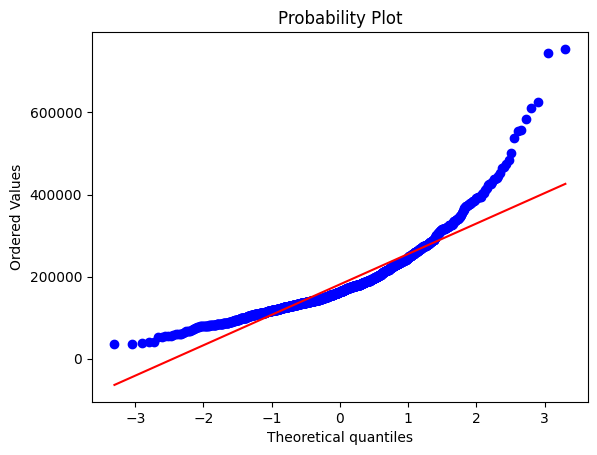

In [10]:
#Vamos dar uma olhada nestes dados
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

Observe que os dados não estão corretamente distribuidos. Precisaremos corrigir isso.

<ipython-input-11-e83a904395ef>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(),cmap='coolwarm',annot = True)


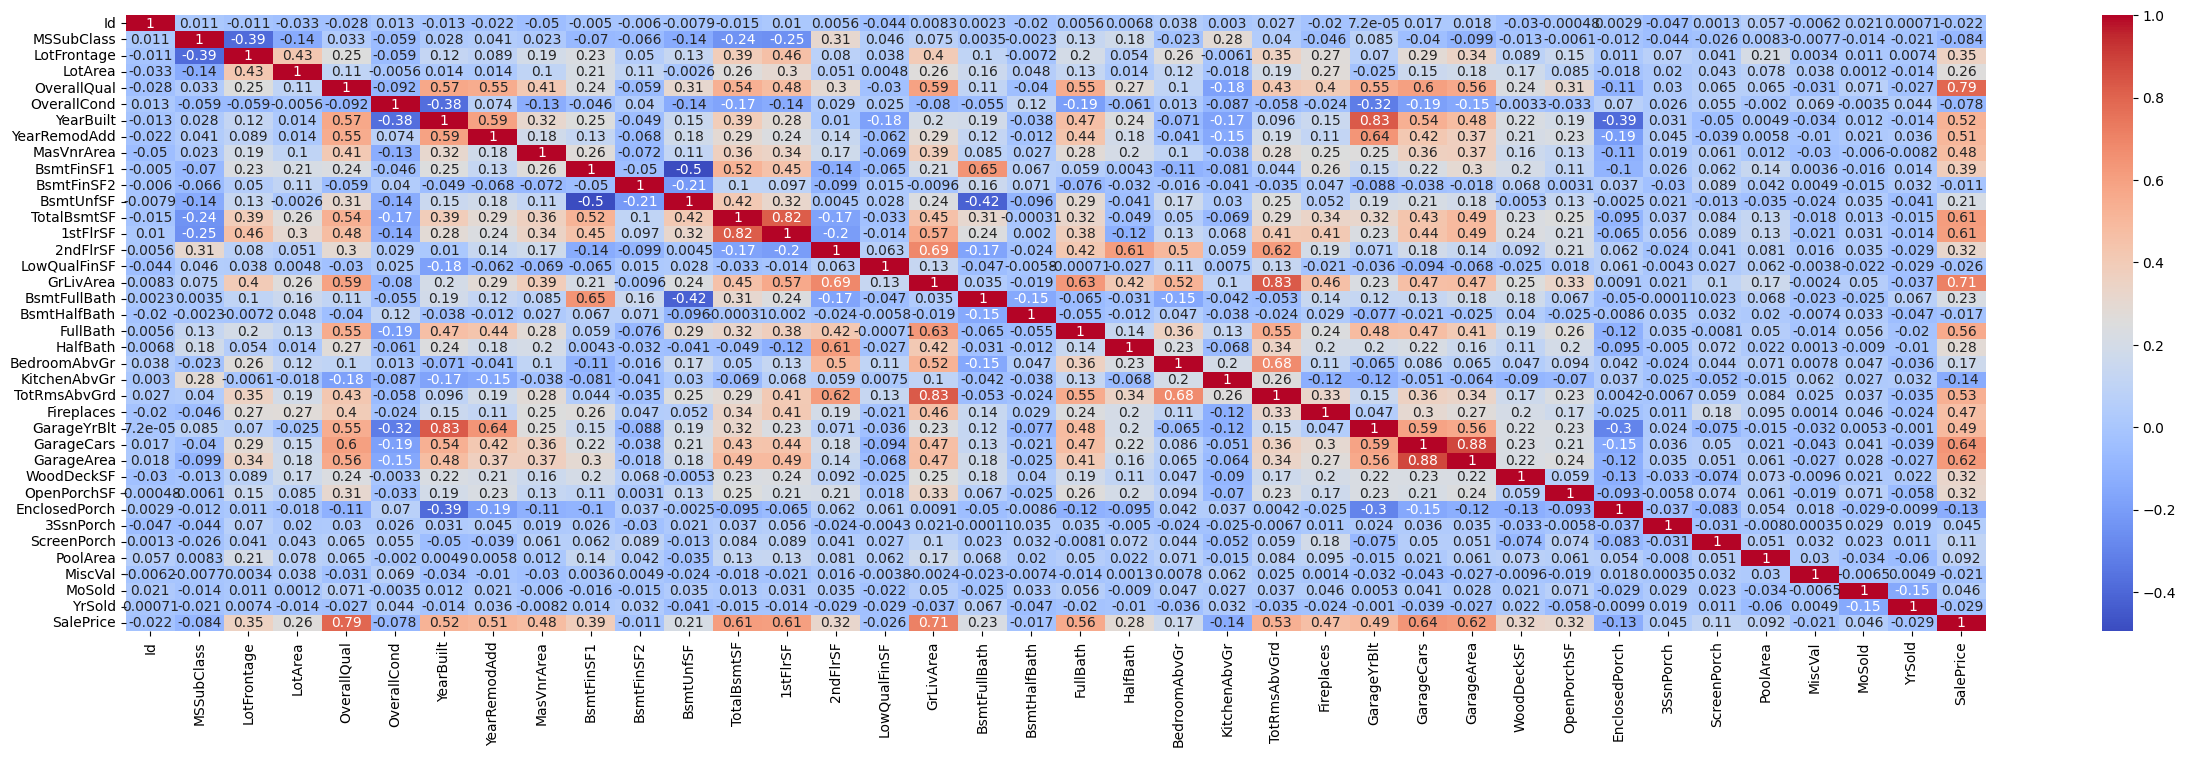

In [11]:
plt.figure(figsize=(30,8))
sns.heatmap(train.corr(),cmap='coolwarm',annot = True)
plt.show()

Com isto podemos verificar os parâmetros com maior correlação com o preço de venda e escolher as features para o nosso modelo de Machine Learning

In [12]:
corr = train.corr()

<ipython-input-12-b40f162577fa>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train.corr()


In [13]:
corr[corr['SalePrice']>0.3].index

Index(['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice'],
      dtype='object')

In [14]:
train = train[['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice']]
test=test[['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF']]

Vamos trabalhar somente com as fetaures que tem uma correlação maior que 0.3 com a feature 'SalePrice' que representa o preço de venda que estamos tentando predizer.

### Feature Engineering

Vamos converter todas as colunas em numéricos ou categóricos

In [15]:
#Missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrArea,8,0.005479
FullBath,0,0.000000
OpenPorchSF,0,0.000000
WoodDeckSF,0,0.000000
GarageArea,0,0.000000
GarageCars,0,0.000000
Fireplaces,0,0.000000
TotRmsAbvGrd,0,0.000000


Como podemos ver nos parâmetros temos muitos valores faltantes. Por causa disto devemos descartar eles da nossa base de dados. Vamos descartar os parâmetros cujo valor total é maior que 81.

In [16]:
train = train.drop((missing_data[missing_data['Total'] > 81]).index,1)

<ipython-input-16-6521d0cbf5ba>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train = train.drop((missing_data[missing_data['Total'] > 81]).index,1)


Faremos o mesmo com os dados de teste.

In [17]:
total_test = test.isnull().sum().sort_values(ascending=False)
percent_test = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_test, percent_test], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
LotFrontage,227,0.155586
GarageYrBlt,78,0.053461
MasVnrArea,15,0.010281
GarageArea,1,0.000685
BsmtFinSF1,1,0.000685
TotalBsmtSF,1,0.000685
GarageCars,1,0.000685
TotRmsAbvGrd,0,0.000000
WoodDeckSF,0,0.000000
Fireplaces,0,0.000000


In [18]:
test = test.drop((missing_data[missing_data['Total'] > 78]).index,1)

<ipython-input-18-81f7f454e604>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test = test.drop((missing_data[missing_data['Total'] > 78]).index,1)


In [19]:
test.isnull().sum().sort_values(ascending=False).head(20)

GarageYrBlt     78
MasVnrArea      15
BsmtFinSF1       1
TotalBsmtSF      1
GarageArea       1
GarageCars       1
OverallQual      0
TotRmsAbvGrd     0
WoodDeckSF       0
Fireplaces       0
GrLivArea        0
FullBath         0
YearBuilt        0
2ndFlrSF         0
1stFlrSF         0
YearRemodAdd     0
OpenPorchSF      0
dtype: int64

In [20]:
train.isnull().sum().sort_values(ascending = False).head(20)

GarageYrBlt     81
MasVnrArea       8
OverallQual      0
TotRmsAbvGrd     0
OpenPorchSF      0
WoodDeckSF       0
GarageArea       0
GarageCars       0
Fireplaces       0
FullBath         0
YearBuilt        0
GrLivArea        0
2ndFlrSF         0
1stFlrSF         0
TotalBsmtSF      0
BsmtFinSF1       0
YearRemodAdd     0
SalePrice        0
dtype: int64

Agora vamos tratar os dados faltantes, para isto vamos filtrar os dados categóricos em uma máscara

In [21]:
categorical_feature_mask = train.dtypes==object
categorical_cols = train.columns[categorical_feature_mask].tolist()

In [22]:
categorical_feature_mask_test = test.dtypes==object
categorical_cols_test = test.columns[categorical_feature_mask_test].tolist()

In [23]:
train.head()

,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice
0,7,2003,2003,196.0,706,856,856,854,1710,2,8,0,2003.0,2,548,0,61,208500
1,6,1976,1976,0.0,978,1262,1262,0,1262,2,6,1,1976.0,2,460,298,0,181500
2,7,2001,2002,162.0,486,920,920,866,1786,2,6,1,2001.0,2,608,0,42,223500
3,7,1915,1970,0.0,216,756,961,756,1717,1,7,1,1998.0,3,642,0,35,140000
4,8,2000,2000,350.0,655,1145,1145,1053,2198,2,9,1,2000.0,3,836,192,84,250000


In [24]:
test.head()

,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF
0,5,1961,1961,0.0,468.0,882.0,896,0,896,1,5,0,1961.0,1.0,730.0,140,0
1,6,1958,1958,108.0,923.0,1329.0,1329,0,1329,1,6,0,1958.0,1.0,312.0,393,36
2,5,1997,1998,0.0,791.0,928.0,928,701,1629,2,6,1,1997.0,2.0,482.0,212,34
3,6,1998,1998,20.0,602.0,926.0,926,678,1604,2,7,1,1998.0,2.0,470.0,360,36
4,8,1992,1992,0.0,263.0,1280.0,1280,0,1280,2,5,0,1992.0,2.0,506.0,0,82


In [25]:
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(train['GarageYrBlt'].mean())
train['MasVnrArea'] = train['MasVnrArea'].fillna(train['MasVnrArea'].mean())

Com tudo pronto, agora podemos escolher algumas features para nosso modelo. Para isso vamos usar novamente uma matriz de correlação e vamos escolher aquelas que possuem maior correlação com a variável 'SalePrice', ou preço de venda.

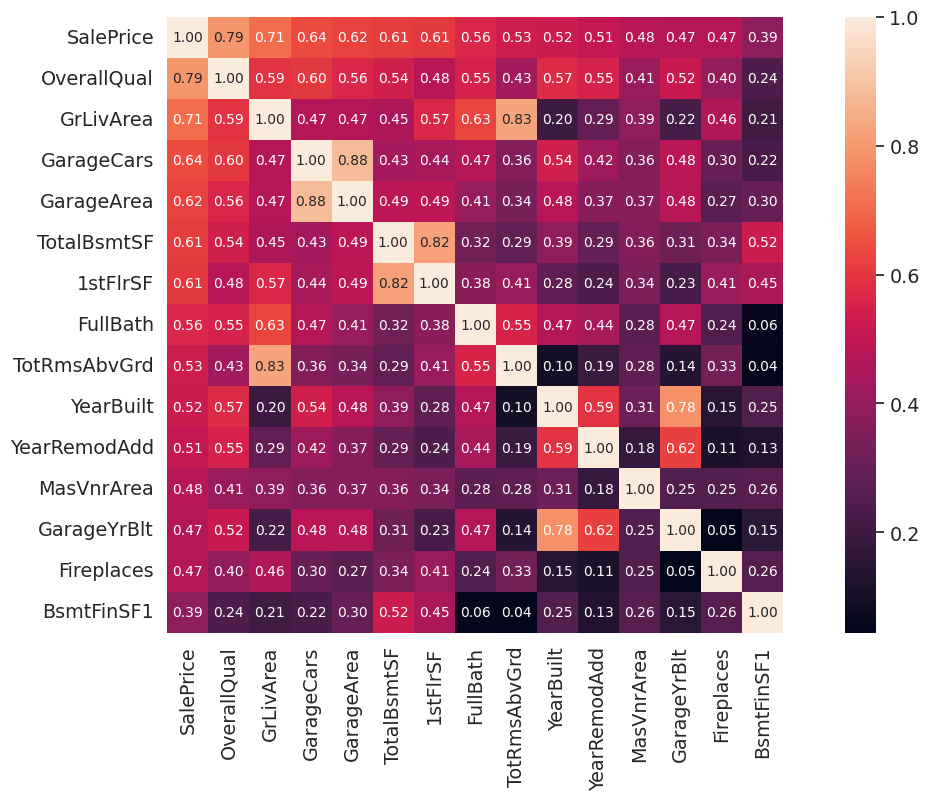

In [26]:
#saleprice correlation matrix
k = 15 #number of variables for heatmap
plt.figure(figsize=(16,8))
corrmat = train.corr()
# picking the top 15 correlated features
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [27]:
train = train[cols]

In [28]:
cols

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'GarageYrBlt', 'Fireplaces',
       'BsmtFinSF1'],
      dtype='object')

In [29]:
#Vamos dropar a coluna'SalePrice'da base de teste, já que ela é o alvo da nossa predição.
test=test[cols.drop('SalePrice')]

In [30]:
test.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,MasVnrArea,GarageYrBlt,Fireplaces,BsmtFinSF1
0,5,896,1.0,730.0,882.0,896,1,5,1961,1961,0.0,1961.0,0,468.0
1,6,1329,1.0,312.0,1329.0,1329,1,6,1958,1958,108.0,1958.0,0,923.0
2,5,1629,2.0,482.0,928.0,928,2,6,1997,1998,0.0,1997.0,1,791.0
3,6,1604,2.0,470.0,926.0,926,2,7,1998,1998,20.0,1998.0,1,602.0
4,8,1280,2.0,506.0,1280.0,1280,2,5,1992,1992,0.0,1992.0,0,263.0


In [31]:
#Por fim, vamos preeencher os valores NULL com a média dos valores.
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(test['GarageYrBlt'].mean())
test['MasVnrArea'] = test['MasVnrArea'].fillna(test['MasVnrArea'].mean())
test['GarageCars'] = test['GarageCars'].fillna(test['GarageCars'].mean())
test['GarageArea'] = test['GarageArea'].fillna(test['GarageArea'].mean())
test['BsmtFinSF1'] = test['BsmtFinSF1'].fillna(test['BsmtFinSF1'].mean())
test['TotalBsmtSF'] = test['TotalBsmtSF'].fillna(test['TotalBsmtSF'].mean())

### Regressão

Com os dados devidamente preparados podemos começar a treinar nossos modelos de regressão. Primeiro precisamos separar nossos dados em um array X que contém as features de treinamento, e um array Y com a feature alvo, neste caso o Preço 'SalePrice'. Vamos aproveitar também para descaratar a coluna 'Address' (Endereço) porque ela contém somente texto e não podemos aproveitar ela em nosso modelo.  

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop('SalePrice', axis=1), train['SalePrice'], test_size=0.3, random_state=101)

In [33]:
y_train= y_train.values.reshape(-1,1)
y_test= y_test.values.reshape(-1,1)

from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)
y_train = sc_X.fit_transform(y_train)
y_test = sc_y.fit_transform(y_test)

In [34]:
X_train

array([[ 1.37391375,  2.5236405 ,  0.31454703, ...,  0.46520725,
         0.58626866,  0.07421157],
       [-1.53923947, -0.2856721 ,  0.31454703, ..., -0.54640203,
        -0.97000815, -1.01837681],
       [ 0.64562544, -0.01580724,  0.31454703, ...,  1.2660646 ,
        -0.97000815, -1.01837681],
       ...,
       [-0.08266286,  0.08903234,  0.31454703, ...,  0.04370339,
         0.58626866, -0.83476756],
       [ 0.64562544,  0.03855402,  0.31454703, ...,  1.09746305,
         0.58626866,  1.86950201],
       [-0.81095116, -0.70308897, -1.02489906, ..., -0.84145473,
        -0.97000815,  1.58388762]])

In [35]:
#Criando e treinando um modelo de Regressão Linear
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

In [36]:
lm.fit(X_train,y_train)
print(lm)

LinearRegression()


In [37]:
predictions = lm.predict(X_test)
predictions= predictions.reshape(-1,1)

In [38]:
from sklearn import metrics

In [39]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.2910540797178433
RMSE: 0.5476838141164808


In [40]:
#Criando e treinando um modelo de Árvore de Regressão
from sklearn.tree import DecisionTreeRegressor
dtreg = DecisionTreeRegressor(random_state = 100)
dtreg.fit(X_train, y_train)

DecisionTreeRegressor(random_state=100)

In [41]:
dtr_pred = dtreg.predict(X_test)
dtr_pred= dtr_pred.reshape(-1,1)

In [42]:
print('MAE:', metrics.mean_absolute_error(y_test, dtr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, dtr_pred)))

MAE: 0.3327904077116327
RMSE: 0.4793729072142496


In [73]:
#Criando e treinando um modelo de SVR - RBF
from sklearn.svm import SVR
regressor = SVR(kernel='rbf')
regressor.fit(X_train,y_train)
predictions = regressor.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.23401679589999025
RMSE: 0.43584950044131243


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [72]:
#Criando e treinando um modelo de SVR - LINEAR
regressor = SVR(kernel='linear')
regressor.fit(X_train,y_train)
predictions = regressor.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE: 0.28377561457082984
RMSE: 0.5498036544436005


In [71]:
#Criando e treinando um modelo de SVR - POLINOMIAL
regressor = SVR(kernel='poly')
regressor.fit(X_train,y_train)
predictions = regressor.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE: 0.3350799255400618
RMSE: 0.7520148371239825
